In [1]:
import jupyter_utils as j

j.reload(j)

In [114]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [186]:
data = pd.read_csv('sparkify_data_final.csv')
data = data.drop(['userId'] ,axis = 1)

pd.set_option('use_inf_as_na', True)

# data['days_time_away'] = (data.session_avg_time_away / data.n_days) / data.avg_session_duration

data['days_time_away'] = (data.session_avg_time_away / data.avg_session_duration) / data.n_days 

print(len(data))

data = data.dropna()

print(len(data))

data = data.drop(['state'], axis = 1)

448
448


In [187]:
data.head(10)

,wa,va,nd,fl,ny,mt,avg_daily_actions,session_avg_time_away,n_songs,or,ne,il,nm,sd,n_home,md,wi,nv,id,ak,n_downgrades,ca,session_avg_playback,n_upgrades,la,vt,sc,session_avg_songs,co,canceled,session_avg_settings,in,session_avg_help,n_errors,al,ks,ok,ut,ct,session_avg_home,n_days,dc,mi,tx,n_friends,session_avg_errors,mn,session_avg_likes,n_settings,male,n_added_to_playlist,ar,nh,tn,n_help,n_ads,oh,pa,nj,ky,time_window,n_likes,paid,ga,session_avg_ads,me,n_actions,ia,ma,avg_session_duration,hi,n_sess,n_dislikes,mo,session_avg_friends,session_avg_dislikes,nc,wv,ri,session_avg_added_playlist,session_avg_actions,az,ms,days_time_away
0,0,0,0,0,0,0,68.500000,66.022500,96,0,0,0,0,0,3,0,0,0,0,0,0,0,1.024795,0,0,0,0,13.689840,0,1,0.000000,0,0.000000,0,0,0,0,0,1,0.427807,2,0,0,0,3,0.000000,0,0.570410,0,0,1,0,0,0,0,22,0,0,0,0,73.035000,4,0,0,3.137255,0,137,0,0,3.507733,0,2,3,0,0.427807,0.427807,0,0,0,0.142602,19.536542,0,0,9.410992
1,0,0,0,0,0,0,65.833333,166.991528,310,0,0,1,0,0,23,0,0,0,0,0,0,0,0.997185,1,0,0,0,14.141261,0,1,0.091234,0,0.045617,0,0,0,0,0,0,1.049190,6,0,0,0,2,0.000000,0,0.684255,2,1,6,0,0,0,1,11,0,0,0,0,689.887778,15,0,0,0.501787,0,395,0,0,5.758219,0,5,5,0,0.091234,0.228085,0,0,0,0.273702,18.018703,0,0,4.833426
2,0,0,0,0,0,0,30.400000,47.248056,112,0,0,0,0,0,7,0,0,0,0,0,0,0,0.972627,1,0,0,0,13.850435,0,1,0.123665,0,0.247329,0,0,0,0,0,0,0.865652,5,0,0,0,2,0.000000,0,0.989317,1,0,3,0,0,0,2,9,0,1,0,0,197.078611,8,1,0,1.112981,0,152,0,0,2.761294,0,5,0,0,0.247329,0.000000,0,0,0,0.370994,18.797018,0,0,3.422168
3,0,0,0,0,0,0,28.000000,522.412639,62,0,0,0,0,0,2,0,0,0,0,0,0,0,1.033783,0,0,0,0,14.591096,0,0,0.706021,0,0.470681,0,0,0,0,0,0,0.470681,3,0,0,1,3,0.000000,0,0.706021,3,1,2,0,0,0,2,6,0,0,0,0,1049.074444,3,0,0,1.412042,0,84,0,0,2.938208,0,3,1,0,0.706021,0.235340,0,0,0,0.470681,19.768582,0,0,59.266589
4,0,0,0,0,0,0,107.800000,53.600208,1826,0,0,0,0,0,70,0,0,0,0,0,0,0,1.067369,0,0,0,0,14.460789,0,1,0.118791,0,0.079194,0,0,0,0,0,0,0.554357,20,0,0,0,26,0.000000,0,0.807777,15,0,45,0,0,0,10,1,0,0,1,0,983.875833,102,1,0,0.007919,0,2156,0,0,14.717388,0,17,15,0,0.205904,0.118791,0,0,0,0.356372,17.074185,0,0,0.182098
5,0,0,0,0,0,0,54.666667,87.977986,266,0,0,0,0,0,17,0,0,0,0,0,0,0,1.013841,0,0,0,0,14.530005,0,1,0.109248,0,0.000000,2,0,0,0,0,0,0.928609,6,0,0,0,3,0.109248,0,0.873985,2,1,8,0,0,0,0,1,0,0,0,1,370.218889,16,1,0,0.054624,0,328,0,0,7.115083,0,5,1,0,0.163872,0.054624,0,0,0,0.436993,17.916698,0,0,2.060833
6,1,0,0,0,0,0,40.000000,95.152480,462,0,0,0,0,0,36,0,0,0,0,0,0,0,1.013385,0,0,0,0,14.531475,0,0,0.157267,0,0.094360,0,0,0,0,0,0,1.132323,15,0,0,0,16,0.000000,0,0.377441,5,1,6,0,0,0,3,35,0,0,0,0,1363.927778,12,0,0,1.100869,0,600,0,0,3.818930,0,15,4,0,0.503255,0.125814,0,0,0,0.188720,18.872046,0,0,1.661067
7,0,0,0,0,0,0,25.833333,60.725833,122,0,0,0,0,0,6,0,0,0,0,0,0,0,1.054349,0,0,0,0,15.375998,0,1,0.126033,0,0.000000,0,0,0,0,0,0,0.756197,6,0,0,0,2,0.000000,0,0.630164,1,1,4,0,0,0,0,9,0,0,0,0,372.289444,5,0,1,1.134295,0,155,0,0,1.925077,0,7,3,0,0.252066,0.378098,0,0,0,0.504131,19.535079,0,0,5.257437
8,0,0,0,0,0,0,18.625000,201.516190,112,0,0,0,0,0,6,0,0,0,0,0,0,0,1.069652,0,0,0,0,15.384615,0,0,0.412088,1,0.000000,0,0,0,0,0,0,0.824176,8,0,0,0,6,0.000000,0,0.824176,3,1,0,0,0,0,0,13,0,0,0,0,1417.893333,6,0,0,1.785714,0,149,0,0,1.202651,0,8,0,0,0.824176,0.000000,0,0,0,0.000000,20.467033,0,0,20.944999
9,0,0,0,0,0,0,138.222222,269.713125,1048,0,0,1,0,0,43,0,0,0,0,0,0,0,1.005280,0,0,0,0,14.385395,0,0,0.041180,0,0.150992,1,0,0,0,0,0,0.590240,9,0,0,0,21,0.013727,0,0.686326,3,0,25,0,0,0,11,0,0,0,0,0,1151.704167,50,1,0,0.000000,0,1244,0,0,21.700945,0,5,10,0,0.288257,0.137265,0,0,0,0.343163,17.075793,0,0,1.380959


In [5]:
data.canceled.value_counts()

0    17275
1     5003
Name: canceled, dtype: int64

In [6]:
data.male.value_counts()

1    11651
0    10627
Name: male, dtype: int64

In [7]:
data.paid.value_counts()

1    11275
0    11003
Name: paid, dtype: int64

In [223]:
def plot_roc_curve(y_test, y_predictions, model, action = 'Training'):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'{action} - ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary'))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .2, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    # Train
    y_predicted = model.predict(X_train)
    plot_roc_curve(y_train, y_predicted, model)
    plot_metrics(y_train, y_predicted)
    
    # Testing
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
    return model

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label): 
    gbl = GradientBoostingClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, random_state = 42)
    return train_model(df, label, gbl)

def train_gs_logistic_regression(df, label):
    
    grid_values = {
        'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],  
        'penalty': [ 'l2' ], 
        'C': np.logspace(-4, 4, 20),
        'max_iter': [100, 200, 300]
    }

    lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', random_state = 42)
    lg_gs = GridSearchCV(lr, param_grid = grid_values, return_train_score = True, verbose = False, n_jobs = -1, cv = 10)
    
    return train_model(df, label, lg_gs)
    

In [189]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Filter average or absolute columns
features_to_normalize = list(filter(lambda column_name: '_' in column_name, data.columns))

_x = data.copy()
_x[features_to_normalize] = RobustScaler().fit_transform(_x[features_to_normalize])
# _x = _x.drop(list(filter(lambda column_name: '_' in column_name, _x.columns)), axis = 1)

_x.head(10)

,wa,va,nd,fl,ny,mt,avg_daily_actions,session_avg_time_away,n_songs,or,ne,il,nm,sd,n_home,md,wi,nv,id,ak,n_downgrades,ca,session_avg_playback,n_upgrades,la,vt,sc,session_avg_songs,co,canceled,session_avg_settings,in,session_avg_help,n_errors,al,ks,ok,ut,ct,session_avg_home,n_days,dc,mi,tx,n_friends,session_avg_errors,mn,session_avg_likes,n_settings,male,n_added_to_playlist,ar,nh,tn,n_help,n_ads,oh,pa,nj,ky,time_window,n_likes,paid,ga,session_avg_ads,me,n_actions,ia,ma,avg_session_duration,hi,n_sess,n_dislikes,mo,session_avg_friends,session_avg_dislikes,nc,wv,ri,session_avg_added_playlist,session_avg_actions,az,ms,days_time_away
0,0,0,0,0,0,0,-0.063579,-0.229447,-0.417567,0,0,0,0,0,-0.500000,0,0,0,0,0,0.0,0,0.262967,-1.0,0,0,0,-1.723637,0,1,-1.318481,0,-1.065205,0.0,0,0,0,0,1,-0.828040,-0.533333,0,0,0,-0.333333,0.000000,0,-0.697104,-0.500,0,-0.465116,0,0,0,-0.428571,0.516129,0,0,0,0,-1.648777,-0.356877,0,0,3.158362,0,-0.415341,0,0,-0.492921,0,-0.538462,-0.226415,0,1.035328,2.796774,0,0,0,-1.932541,0.894349,0,0,1.769328
1,0,0,0,0,0,0,-0.112019,0.649705,-0.220740,0,0,1,0,0,-0.083333,0,0,0,0,0,0.0,0,-0.442540,0.0,0,0,0,-0.859734,0,1,-0.021461,0,-0.466486,0.0,0,0,0,0,0,1.344781,-0.266667,0,0,0,-0.380952,0.000000,0,-0.196717,-0.250,1,-0.310078,0,0,0,-0.285714,0.043011,0,0,0,0,-0.705178,-0.193309,0,0,0.192973,0,-0.222264,0,0,-0.226773,0,-0.307692,-0.075472,0,-1.029571,0.844879,0,0,0,-0.973990,0.030799,0,0,0.800265
2,0,0,0,0,0,0,-0.755677,-0.392919,-0.402851,0,0,0,0,0,-0.416667,0,0,0,0,0,0.0,0,-1.070042,0.0,0,0,0,-1.416300,0,1,0.439587,0,2.180971,0.0,0,0,0,0,0,0.702993,-0.333333,0,0,0,-0.380952,0.000000,0,1.144140,-0.375,0,-0.403101,0,0,0,-0.142857,-0.043011,0,1,0,0,-1.459028,-0.297398,1,0,0.880680,0,-0.404116,0,0,-0.581197,0,-0.307692,-0.452830,0,-0.071917,-1.384200,0,0,0,-0.262627,0.473609,0,0,0.501505
3,0,0,0,0,0,0,-0.799273,3.744411,-0.448839,0,0,0,0,0,-0.520833,0,0,0,0,0,0.0,0,0.492618,-1.0,0,0,0,0.001136,0,0,8.718605,0,5.112439,0.0,0,0,0,0,0,-0.678124,-0.466667,0,0,1,-0.333333,0.000000,0,-0.101046,-0.125,1,-0.434109,0,0,0,-0.142857,-0.172043,0,0,0,0,-0.155730,-0.371747,0,0,1.217178,0,-0.455005,0,0,-0.560275,0,-0.461538,-0.377358,0,2.742184,0.915787,0,0,0,0.466246,1.026365,0,0,12.323671
4,0,0,0,0,0,0,0.650318,-0.337610,1.173603,0,0,0,0,0,0.895833,0,0,0,0,0,0.0,0,1.350823,-1.0,0,0,0,-0.248239,0,1,0.370298,0,-0.025793,0.0,0,0,0,0,0,-0.385529,0.666667,0,0,0,0.761905,0.000000,0,0.346207,1.375,0,0.899225,0,0,0,1.000000,-0.387097,0,0,1,0,-0.255464,1.100372,1,0,-0.362719,0,1.095603,0,0,0.832761,0,0.615385,0.679245,0,-0.326064,-0.223255,0,0,0,-0.369535,-0.506569,0,0,-0.184412
5,0,0,0,0,0,0,-0.314865,-0.038278,-0.261209,0,0,0,0,0,-0.208333,0,0,0,0,0,0.0,0,-0.016926,-1.0,0,0,0,-0.115777,0,1,0.234637,0,-1.065205,1.0,0,0,0,0,0,0.923139,-0.266667,0,0,0,-0.333333,4.890241,0,0.637217,-0.250,1,-0.248062,0,0,0,-0.428571,-0.387097,0,0,0,1,-1.194175,-0.178439,1,0,-0.310167,0,-0.272404,0,0,-0.066307,0,-0.307692,-0.377358,0,-0.583931,-0.850358,0,0,0,0.219933,-0.027235,0,0,0.213312
6,1,0,0,0,0,0,-0.581290,0.024192,-0.080938,0,0,0,0,0,0.187500,0,0,0,0,0,0.0,0,-0.028578,-1.0,0,0,0,-0.112964,0,0,0.917293,0,0.173265,0.0,0,0,0,0,0,1.635474,0.333333,0,0,0,0.285714,0.000000,0,-1.545271,0.125,1,-0.310078,0,0,0,0.000000,1.075269,0,0,0,0,0.325901,-0.237918,0,0,0.867052,0,-0.068849,0,0,-0.456119,0,0.461538,-0.150943,0,1.498201,-0.154620,0,0,0,-1.595343,0.516295,0,0,0.128683
7,0,0,0,0,0,0,-0.838632,-0.275566,-0.393654,0,0,0,0,0,-0.437500,0,0,0,0,0,0.0,0,1.018150,-1.0,0,0,0,1.503234,0,1,0.473254,0,-1.065205,0.0,0,0,0,0,0,0.320255,-0.266667,0,0,0,-0.380952,0.000000,0,-0.434465,-0.375,1,-0.372093,0,0,0,-0.428571,-0.043011,0,0,0,0,-1.191008,-0.342007,0,1,0.904662,0,-0.401871,0,0,-0.680090,0,-0.153846,-0.226415,0,-0.042859,2.310965,0,0,0,0.710825,0.893517,0,0,0.890028
8,0,0,0,0,0,0,-0.969573,0.950317,-0.402851,0,0,0,0,0,-0.437500,0,0,0,0,0,0.0,0,1.409164,-1.0,0,0,0,1.519726,0,0,4.539933,1,-1.065205,0.0,0,0,0,0,0,0.557961,-0.133333,0,0,0,-0.190476,0.000000,0,0.418287,-0

In [ ]:
_x[_x.columns[4:]].apply(lambda x: x/_x.time_window, axis = 1)

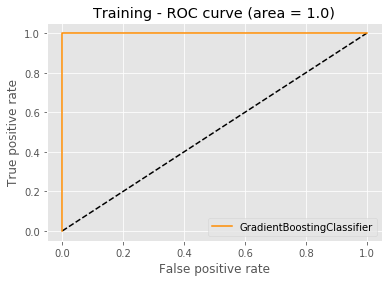

[[ 78   0]
 [  0 280]]

accuracy................. 1.0000
precision................ 1.0000
recall................... 1.0000
auc...................... 1.0000
F1 macro................. 1.0000
F1 micro................. 1.0000
F1 weighted.............. 1.0000
F1 binary................ 1.0000


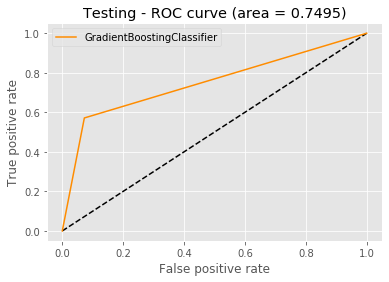

[[12  9]
 [ 5 64]]

accuracy................. 0.8444
precision................ 0.8767
recall................... 0.9275
auc...................... 0.7495
F1 macro................. 0.7665
F1 micro................. 0.8444
F1 weighted.............. 0.8384
F1 binary................ 0.6316


In [190]:
model = train_gradient_boosting(_x, 'canceled')

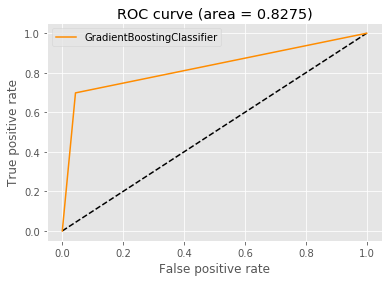

[[1060  458]
 [ 224 4942]]

accuracy................. 0.8980
precision................ 0.9152
recall................... 0.9566
auc...................... 0.8275
F1 macro................. 0.8460
F1 micro................. 0.8980
F1 weighted.............. 0.8948
F1 binary................ 0.7566


In [17]:
model = train_gradient_boosting(_x, 'canceled')

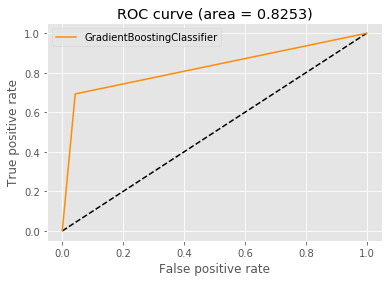

[[1052  466]
 [ 219 4947]]

accuracy................. 0.8975
precision................ 0.9139
recall................... 0.9576
auc...................... 0.8253
F1 macro................. 0.8448
F1 micro................. 0.8975
F1 weighted.............. 0.8942
F1 binary................ 0.7544


In [36]:
model = train_gradient_boosting(_x, 'canceled')

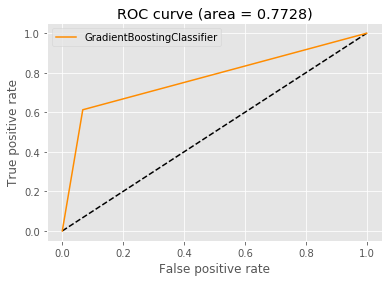

[[19 12]
 [ 7 97]]

accuracy................. 0.8593
precision................ 0.8899
recall................... 0.9327
auc...................... 0.7728
F1 macro................. 0.7887
F1 micro................. 0.8593
F1 weighted.............. 0.8547
F1 binary................ 0.6667


In [43]:
model = train_gradient_boosting(_x, 'canceled')

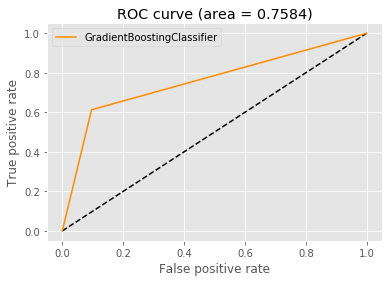

[[19 12]
 [10 94]]

accuracy................. 0.8370
precision................ 0.8868
recall................... 0.9038
auc...................... 0.7584
F1 macro................. 0.7643
F1 micro................. 0.8370
F1 weighted.............. 0.8351
F1 binary................ 0.6333


In [13]:
model = train_gradient_boosting(_x, 'canceled')

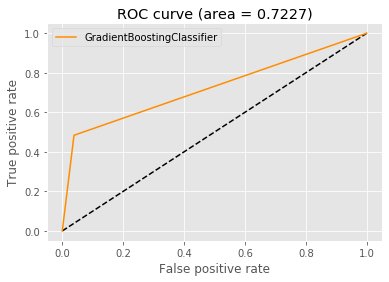

[[ 15  16]
 [  4 100]]

accuracy................. 0.8519
precision................ 0.8621
recall................... 0.9615
auc...................... 0.7227
F1 macro................. 0.7545
F1 micro................. 0.8519
F1 weighted.............. 0.8381
F1 binary................ 0.6000


In [107]:
model = train_gradient_boosting(_x, 'canc')

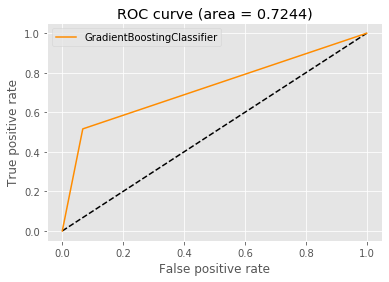

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


In [101]:
model = train_gradient_boosting(_x, 'canc')

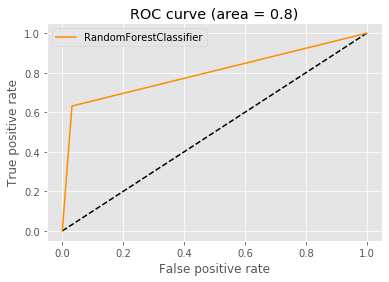

[[ 959  559]
 [ 164 5002]]

accuracy................. 0.8918
precision................ 0.8995
recall................... 0.9683
auc...................... 0.8000
F1 macro................. 0.8294
F1 micro................. 0.8918
F1 weighted.............. 0.8857
F1 binary................ 0.7262


In [8]:
model = train_random_forest(_x, 'canceled')

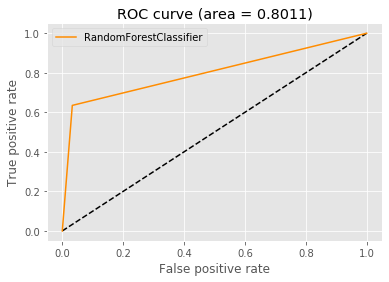

[[ 964  554]
 [ 170 4996]]

accuracy................. 0.8917
precision................ 0.9002
recall................... 0.9671
auc...................... 0.8011
F1 macro................. 0.8297
F1 micro................. 0.8917
F1 weighted.............. 0.8858
F1 binary................ 0.7270


In [13]:
model = train_random_forest(_x, 'canceled')

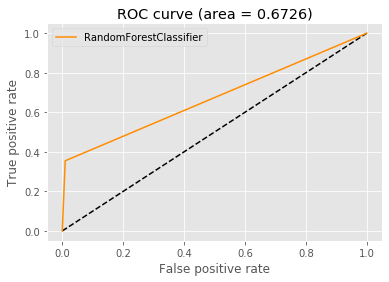

[[ 11  20]
 [  1 103]]

accuracy................. 0.8444
precision................ 0.8374
recall................... 0.9904
auc...................... 0.6726
F1 macro................. 0.7096
F1 micro................. 0.8444
F1 weighted.............. 0.8166
F1 binary................ 0.5116


In [44]:
model = train_random_forest(_x, 'canceled')

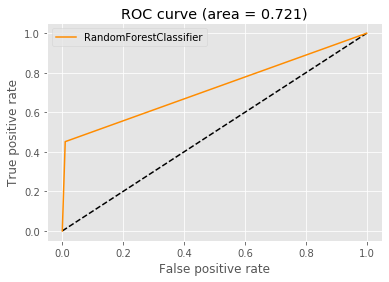

[[ 14  17]
 [  1 103]]

accuracy................. 0.8667
precision................ 0.8583
recall................... 0.9904
auc...................... 0.7210
F1 macro................. 0.7642
F1 micro................. 0.8667
F1 weighted.............. 0.8482
F1 binary................ 0.6087


In [14]:
model = train_random_forest(_x, 'canceled')

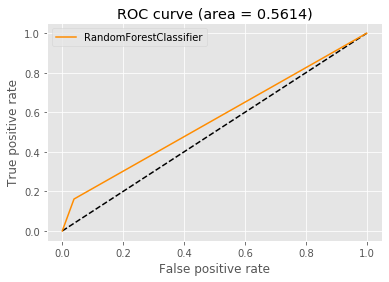

[[  5  26]
 [  4 100]]

accuracy................. 0.7778
precision................ 0.7937
recall................... 0.9615
auc...................... 0.5614
F1 macro................. 0.5598
F1 micro................. 0.7778
F1 weighted.............. 0.7273
F1 binary................ 0.2500


In [102]:
model = train_random_forest(_x, 'canc')

In [ ]:
importances = pd.Series(model.feature_importances_, index = average_columns).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

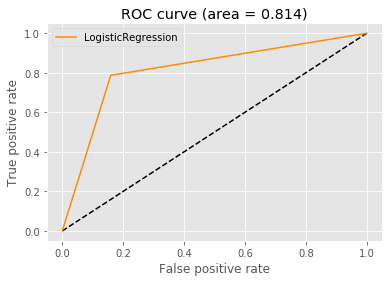

[[1195  323]
 [ 823 4343]]

accuracy................. 0.8285
precision................ 0.9308
recall................... 0.8407
auc...................... 0.8140
F1 macro................. 0.7797
F1 micro................. 0.8285
F1 weighted.............. 0.8363
F1 binary................ 0.6759


In [9]:
model = train_logistic_regression(_x, 'canceled')

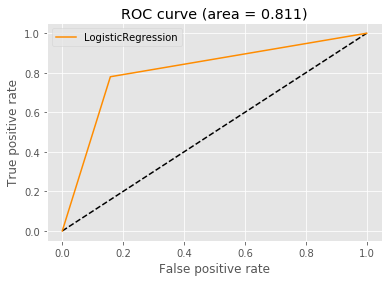

[[1184  334]
 [ 816 4350]]

accuracy................. 0.8279
precision................ 0.9287
recall................... 0.8420
auc...................... 0.8110
F1 macro................. 0.7782
F1 micro................. 0.8279
F1 weighted.............. 0.8355
F1 binary................ 0.6731


In [14]:
model = train_logistic_regression(_x, 'canceled')

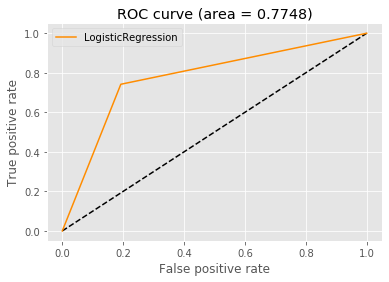

[[23  8]
 [20 84]]

accuracy................. 0.7926
precision................ 0.9130
recall................... 0.8077
auc...................... 0.7748
F1 macro................. 0.7394
F1 micro................. 0.7926
F1 weighted.............. 0.8031
F1 binary................ 0.6216


In [45]:
model = train_logistic_regression(_x, 'canceled')

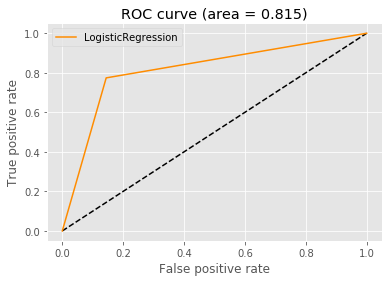

[[24  7]
 [15 89]]

accuracy................. 0.8370
precision................ 0.9271
recall................... 0.8558
auc...................... 0.8150
F1 macro................. 0.7879
F1 micro................. 0.8370
F1 weighted.............. 0.8431
F1 binary................ 0.6857


In [16]:
model = train_logistic_regression(_x, 'canceled')

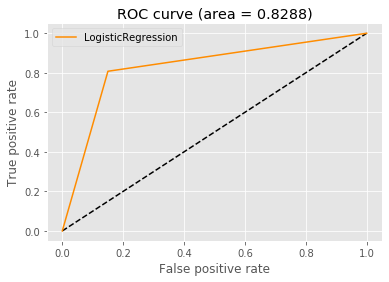

[[ 63  15]
 [ 42 238]]

accuracy................. 0.8408
precision................ 0.9407
recall................... 0.8500
auc...................... 0.8288
F1 macro................. 0.7908
F1 micro................. 0.8408
F1 weighted.............. 0.8485
F1 binary................ 0.6885


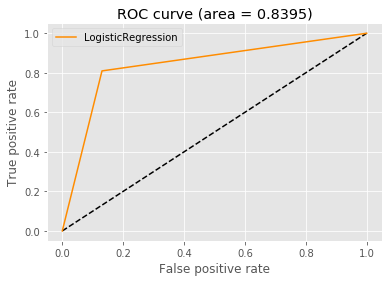

[[17  4]
 [ 9 60]]

accuracy................. 0.8556
precision................ 0.9375
recall................... 0.8696
auc...................... 0.8395
F1 macro................. 0.8128
F1 micro................. 0.8556
F1 weighted.............. 0.8605
F1 binary................ 0.7234


In [174]:
model = train_logistic_regression(_x, 'canceled')

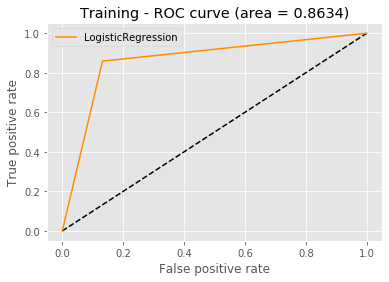

[[ 67  11]
 [ 37 243]]

accuracy................. 0.8659
precision................ 0.9567
recall................... 0.8679
auc...................... 0.8634
F1 macro................. 0.8232
F1 micro................. 0.8659
F1 weighted.............. 0.8722
F1 binary................ 0.7363


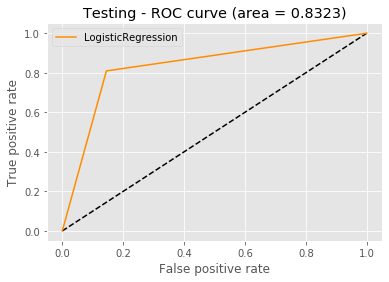

[[17  4]
 [10 59]]

accuracy................. 0.8444
precision................ 0.9365
recall................... 0.8551
auc...................... 0.8323
F1 macro................. 0.8011
F1 micro................. 0.8444
F1 weighted.............. 0.8506
F1 binary................ 0.7083


In [192]:
model = train_logistic_regression(_x, 'canceled')

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


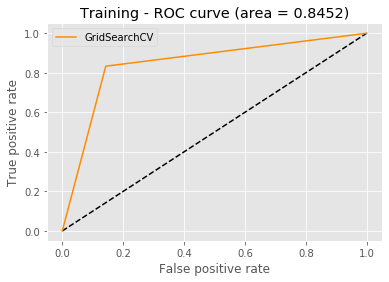

[[ 65  13]
 [ 40 240]]

accuracy................. 0.8520
precision................ 0.9486
recall................... 0.8571
auc...................... 0.8452
F1 macro................. 0.8055
F1 micro................. 0.8520
F1 weighted.............. 0.8591
F1 binary................ 0.7104


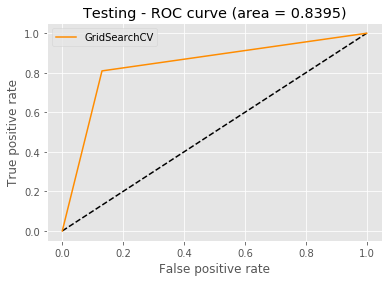

[[17  4]
 [ 9 60]]

accuracy................. 0.8556
precision................ 0.9375
recall................... 0.8696
auc...................... 0.8395
F1 macro................. 0.8128
F1 micro................. 0.8556
F1 weighted.............. 0.8605
F1 binary................ 0.7234


In [224]:
from sklearn.model_selection import GridSearchCV
model = train_gs_logistic_regression(_x, 'canceled')

In [225]:
model.best_params_

{'C': 0.08858667904100823,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [216]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'scorer_',
 'scoring',
 '